We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.


1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
3. Help us understand how the price is predicted (again, a few sentences will suffice).

## Before we make the prediction, we need to import all the packages. 
## Table of contents
1. Explanatory Data Analysis on all numerical variables
2. Correlation analysis to check multicollinearity
3. Polynonial regression
4. PCA analysis
5. Comparison betweem different models

In [149]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# <font color='black'>1. Explanatory Data Analysis</font>

## <font color='Green'>1.1 Check the number of total columns and row lables</font>



In [55]:

df = pd.read_csv(r"C:\Users\xqu\Dropbox\techlent\sales.csv")
df.dropna(subset=['price'], inplace=True)

In [56]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


**Get names of columns**

In [180]:
df.columns

Index(['cost', 'price', 'weight', 'purchase_date', 'product_type',
       'product_level', 'maker', 'ingredient', 'height', 'width', 'depth'],
      dtype='object')

In [107]:
len(df.index)


3186

In [43]:
len(df.columns)

11

## Calculate the missing values percentage for each column

In [57]:

df.isnull().sum()/len(df.index)

cost             0.306026
price            0.000000
weight           0.000942
purchase_date    0.000000
product_type     0.000000
product_level    0.000000
maker            0.257690
ingredient       0.079724
height           0.000000
width            0.000942
depth            0.000942
dtype: float64

In [58]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)


In [63]:
def weight2num(x):
    if type(x) == str: 
        tokens = x.split()
        if len(tokens) == 4:
             return float(tokens[0])*1000 + float(tokens[2])
        else:
            return 0
    else:
        
        return x

In [65]:
train = pd.DataFrame(columns = ['price', 'cost', 'weight', 'height', 'width', 'depth'])               

In [67]:
train['price'] = train_raw['price'].map(lambda x: x if type(x) is float else float(x.strip('$').replace(',', '')))

In [69]:
train['cost'] = train_raw['cost'].map(lambda x: x if type(x) is float else 1000*float(x.strip('$').strip('k')))

In [71]:
train['weight'] = train_raw['weight'].map(weight2num) 

In [72]:
train['height'] = train_raw['height'].map(lambda x: x if type(x) is float else float(x.strip(' meters')))
train['width'] = train_raw['width'].map(lambda x: x if type(x) is float else float(x.strip(' cm')))
train['depth'] = train_raw['depth'].map(lambda x: x if type(x) is float else float(x.strip(' cm')))        

In [73]:
train.head()

,price,cost,weight,height,width,depth
0,300492.0,333000.0,3090.0,2.76,97.0,26.0
1,430570.0,NaN,3030.0,2.67,98.0,26.0
2,213070.0,270000.0,3040.0,3.00,93.0,24.0
3,122659.0,97000.0,2970.0,2.47,101.0,26.0
4,60320.0,59000.0,2930.0,2.71,96.0,25.0


## Generate boxplot to visualize outliers in each numerical variables(As we can see, we have cost and weight showing many outliers, therefore, we choose standardscalar as the scaling method of the model.)

<AxesSubplot:xlabel='cost'>

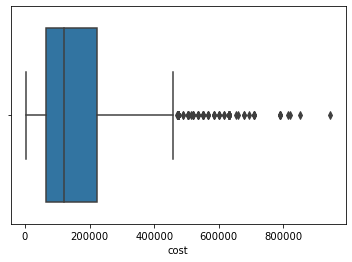

In [109]:
sns.boxplot(x = train["cost"])

<AxesSubplot:xlabel='weight'>

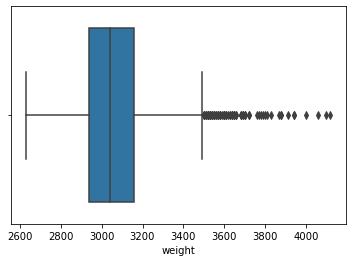

In [85]:
sns.boxplot(x = train["weight"])

<AxesSubplot:xlabel='height'>

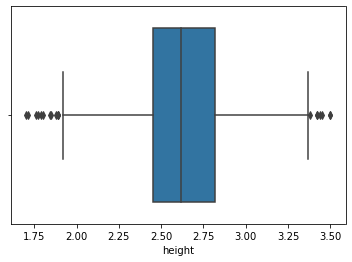

In [86]:
sns.boxplot(x = train["height"])

<AxesSubplot:xlabel='width'>

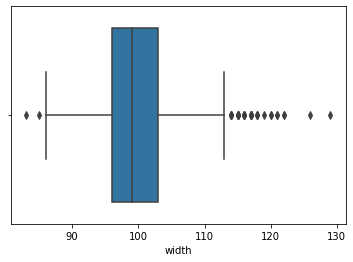

In [87]:
sns.boxplot(x = train["width"])

<AxesSubplot:xlabel='depth'>

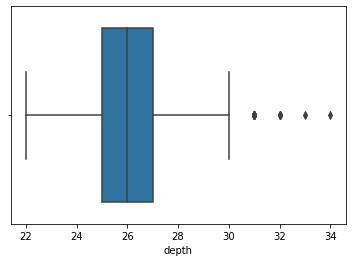

In [88]:
sns.boxplot(x = train["depth"])

# 2.Correlation analysis

## 2.1 Calculate the pearson correlation

In [89]:
train_corr = train.corr(method = 'pearson')

In [91]:
train_corr

,price,cost,weight,height,width,depth
price,1.000000,0.618253,0.301362,0.088917,0.074010,0.076007
cost,0.618253,1.000000,0.347582,0.092488,0.101852,0.103242
weight,0.301362,0.347582,1.000000,0.175936,0.358753,0.349840
height,0.088917,0.092488,0.175936,1.000000,-0.848096,-0.833685
width,0.074010,0.101852,0.358753,-0.848096,1.000000,0.979237
depth,0.076007,0.103242,0.349840,-0.833685,0.979237,1.000000


<AxesSubplot:>

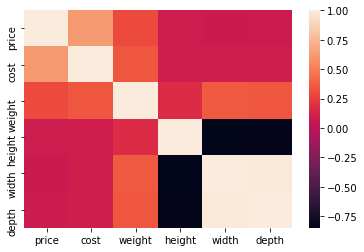

In [92]:
sns.heatmap(train_corr)

## 2.2 Visulize the relationships between these columns using pairplot in seaborn.



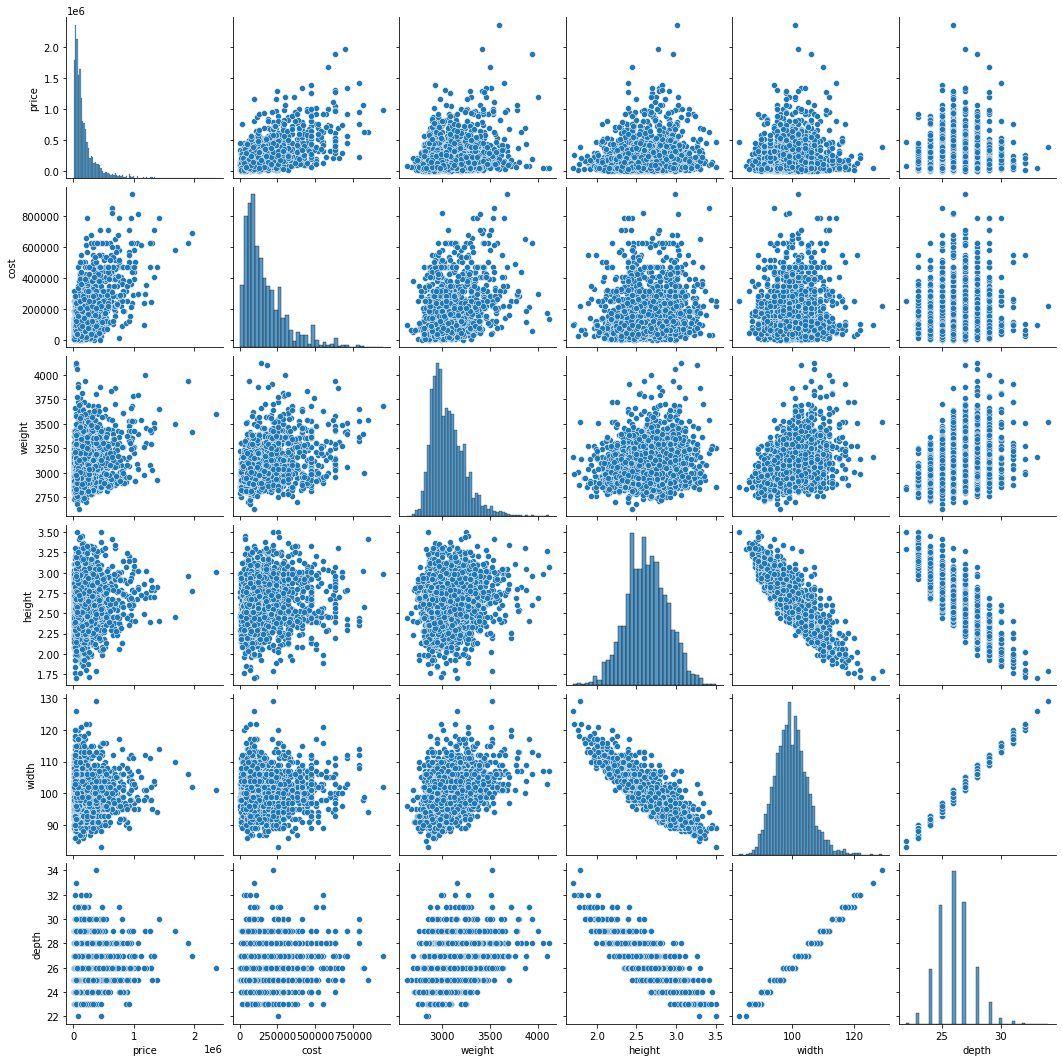

In [94]:
sns.pairplot(train)

### As we can see from the plots above, cost is highly correlated with price. Therefore, we choose cost as the feature when creating simple linear regression model and polynomial regression.

# 3. Linear regression & Polynomial model

## 3.1 Linear regression model

In [98]:
linear = pd.DataFrame(columns = ['price', 'cost'])
linear['price'] = train_raw['price'].map(lambda x: x if type(x) is float else float(x.strip('$').replace(',', '')))
linear['cost'] = train_raw['cost'].map(lambda x: x if type(x) is float else 1000*float(x.strip('$').strip('k')))

In [99]:
features = list(linear.columns)
target = "price"
features.remove(target)

X_train = linear[features]
y_train = linear[target]

In [100]:
X_train = X_train.fillna(X_train.mean())

In [101]:
test = pd.DataFrame(columns = ['price', 'cost'])
test['price'] = test_raw['price'].map(lambda x: x if type(x) is float else float(x.strip('$').replace(',', '')))
test['cost'] = test_raw['cost'].map(lambda x: x if type(x) is float else 1000*float(x.strip('$').strip('k')))

In [102]:
X_test = test[features]
y_test = test[target]

In [103]:
X_test = X_test.fillna(X_train.mean())

In [104]:
model = LinearRegression()


In [105]:
model.fit(X_train, y_train)

LinearRegression()

In [106]:
y_train_pred = model.predict(X_train)

In [150]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.15e+05
train MSE: 2.96e+10
train R2: 0.306


Text(0, 0.5, 'y_train_pred')

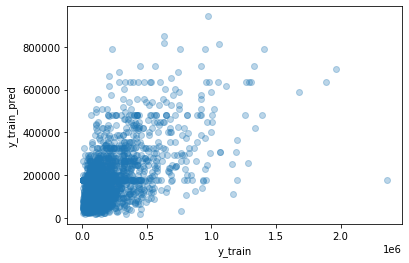

In [110]:
plt.scatter(y_train, y_train_pred, alpha = 0.3)
plt.xlabel('y_train')
plt.ylabel('y_train_pred')


In [111]:
model.coef_

array([0.98206553])

In [112]:
model.intercept_

14657.539917452465

In [113]:
def plot_cost_price(cost, price, model):
    plt.scatter(cost, price, alpha=0.3)
    x = np.linspace(0, 1e6)
    y = model.predict(x.reshape(-1,1))
    plt.plot(x, y, color='r')
    plt.xlabel('cost')
    plt.ylabel('price')
    plt.xlim([0,1e6])
    plt.ylim([0,2e6])
    plt.show()

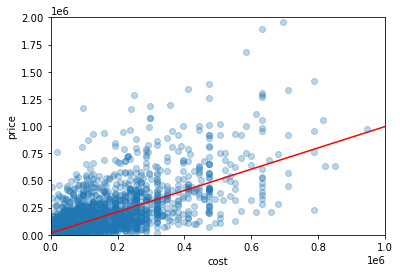

In [114]:
plot_cost_price(train.cost, train.price, model)

In [115]:
y_test_pred = model.predict(X_test)

In [116]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.44e+05
test MSE: 5.62e+10
test R2: 0.348


Text(0, 0.5, 'y_test_pred')

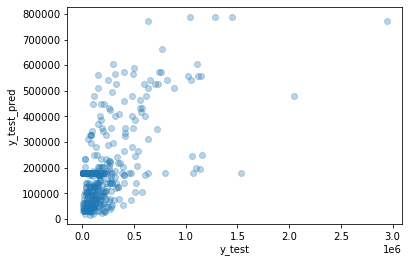

In [117]:
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

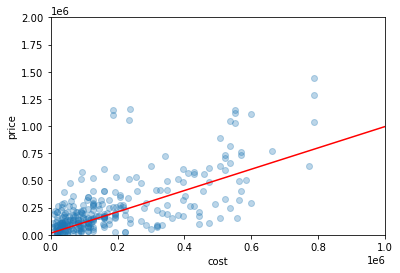

In [159]:
plot_cost_price(test.cost, test.price, model)

## 3.2 Polynomial model


In [118]:
pf = PolynomialFeatures(degree=3)

In [119]:
pf.fit_transform(X_train)

array([[1.00000000e+00, 3.33000000e+05, 1.10889000e+11, 3.69260370e+16],
       [1.00000000e+00, 1.66184183e+05, 2.76171827e+10, 4.58953895e+15],
       [1.00000000e+00, 2.70000000e+05, 7.29000000e+10, 1.96830000e+16],
       ...,
       [1.00000000e+00, 1.66184183e+05, 2.76171827e+10, 4.58953895e+15],
       [1.00000000e+00, 4.40000000e+04, 1.93600000e+09, 8.51840000e+13],
       [1.00000000e+00, 1.28000000e+05, 1.63840000e+10, 2.09715200e+15]])

In [120]:
pf.get_feature_names()

['1', 'x0', 'x0^2', 'x0^3']

In [121]:
pd.DataFrame(pf.transform(X_train), 
             columns=pf.get_feature_names()).head()

,1,x0,x0^2,x0^3
0,1.0,333000.000000,1.108890e+11,3.692604e+16
1,1.0,166184.183143,2.761718e+10,4.589539e+15
2,1.0,270000.000000,7.290000e+10,1.968300e+16
3,1.0,97000.000000,9.409000e+09,9.126730e+14
4,1.0,59000.000000,3.481000e+09,2.053790e+14


In [132]:

steps = [('poly', PolynomialFeatures(degree=2)),
         ('Rescale', StandardScaler()),
         ('lr', LinearRegression())]
model_p = Pipeline(steps)

In [133]:
model_p.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('Rescale', StandardScaler()),
                ('lr', LinearRegression())])

In [134]:
y_train_pred_p = model_p.predict(X_train)

In [135]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred_p)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred_p)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred_p)))

train MAE: 1.11e+05
train MSE: 2.88e+10
train R2: 0.323


Text(0, 0.5, 'y_train_pred')

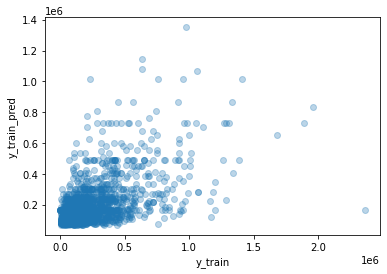

In [136]:
plt.scatter(y_train, y_train_pred_p, alpha = 0.3)
plt.xlabel('y_train')
plt.ylabel('y_train_pred')

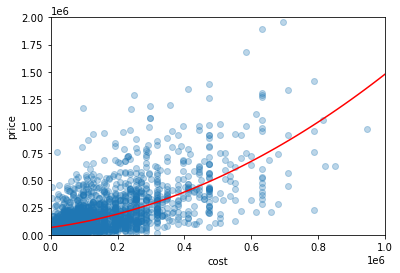

In [137]:
plot_cost_price(train.cost, train.price, model_p)

In [138]:
y_test_pred_p = model_p.predict(X_test)

In [139]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred_p)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred_p)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred_p)))

test MAE: 1.36e+05
test MSE: 5.20e+10
test R2: 0.397


Text(0, 0.5, 'y_test_pred')

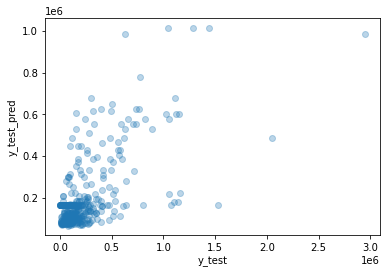

In [140]:
plt.scatter(y_test, y_test_pred_p, alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

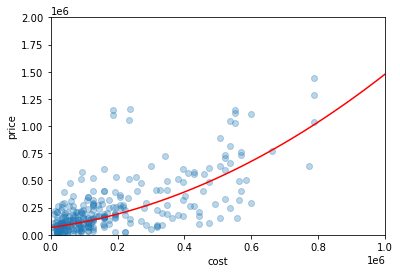

In [141]:
plot_cost_price(test.cost, test.price, model_p)

In [144]:
lr = model_p.steps[2][1]

In [145]:
lr.coef_


array([    0.        , 48870.28142935, 70640.15034721])

In [146]:

MAE_train = []
MAE_test = []
for degree in range(2, 51):
    steps_h = [('poly', PolynomialFeatures(degree = degree)),
               ('Rescale', StandardScaler()),
               ('lr', LinearRegression())]
    model_h = Pipeline(steps_h)
    model_h.fit(X_train, y_train)
    y_train_pred_h = model_h.predict(X_train)
    y_test_pred_h = model_h.predict(X_test)
    MAE_train.append(mean_absolute_error(y_train, y_train_pred_h))
    MAE_test.append(mean_absolute_error(y_test, y_test_pred_h))

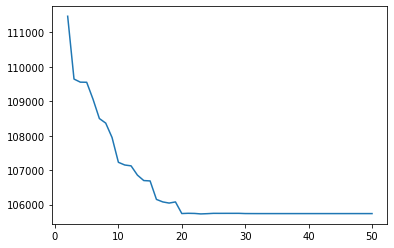

In [147]:
plt.plot(np.linspace(2, 50, 49), MAE_train)

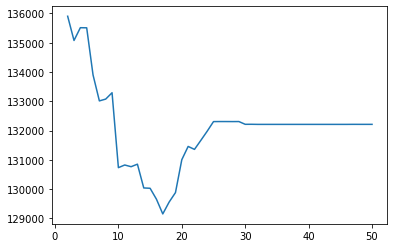

In [148]:
plt.plot(np.linspace(2, 50, 49), MAE_test)

# 4.PCA analysis

In [150]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [151]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)
X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [152]:


from sklearn.base import TransformerMixin
class Transformer(TransformerMixin):
    #What does this class do?
    def __init__(self):
        self.mean = 0
    
    def fit(self, X, y=None):
        #what does this function do?
        #what are the input types? e.g. X here need to be a dataframe
        #what are the output and types?
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x
        
    def weight2num(self, x):
        if type(x) == str: 
            tokens = x.split()
            if len(tokens) == 4:
                return float(tokens[0])*1000 + float(tokens[2])
            else:
                return 0
        else:
            return x
    
    def height2num(self, x):
        if type(x) == str: 
            x = x.strip(' meters')
            return float(x)
        else:
            return x
    
    def width2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
        
    def depth2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
        
    def price2num(x):
        if type(x) == str: 
            x = x.strip('$').replace(',', '')
        return float(x)

In [153]:
steps = [('ctf', Transformer()),
         ('rescale', MinMaxScaler()),
         ('pca', PCA(n_components = 5))]
pipe = Pipeline(steps)
X_train_pca = pipe.fit(X_train)

In [154]:
X_train_pca.steps[2][1].explained_variance_ratio_

array([0.58770344, 0.26613977, 0.13939442, 0.00547071, 0.00129166])

<BarContainer object of 5 artists>

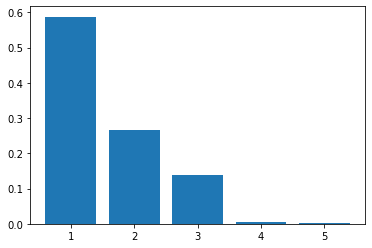

In [155]:

plt.bar([1, 2, 3, 4, 5], X_train_pca.steps[2][1].explained_variance_ratio_)

In [156]:
X_train_pca.steps[2][1].components_

array([[ 3.10313511e-02,  1.13947290e-01, -6.29502738e-01,
         5.37316267e-01,  5.48699009e-01],
       [ 6.02043006e-01,  7.03587518e-01,  3.44728502e-01,
         1.06997547e-01,  1.10555903e-01],
       [ 7.97858571e-01, -5.35932944e-01, -2.34781366e-01,
        -1.02310442e-01, -1.02994483e-01],
       [-1.72263238e-03, -2.90762680e-01,  4.21105751e-01,
        -2.75793973e-01,  8.13671756e-01],
       [ 8.09515856e-05, -3.46718275e-01,  5.02430313e-01,
         7.83143034e-01, -1.18478686e-01]])

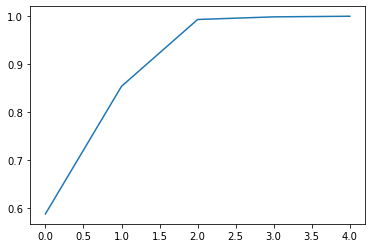

In [157]:
import numpy as np

plt.plot(np.cumsum(X_train_pca.steps[2][1].explained_variance_ratio_))

In [158]:
steps = [('ctf', Transformer()),
         ('rescale', MinMaxScaler()),
         ('pca', PCA(n_components = 2)),
         ('lr', LinearRegression())]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

In [159]:
y_train_pred = model.predict(X_train)

In [160]:
y_test_pred = model.predict(X_test)

In [161]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.20e+05
train MSE: 3.20e+10
train R2: 0.248


In [162]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.51e+05
test MSE: 6.41e+10
test R2: 0.256


# 5. Conclusion
After we compare the R square between polynomial and PCA analysis, we can tell polynomial performs better than PCA. However, when it comes to bias-variance tradeoff, PCA has lower variance as the R square between test and train dataset is closer.

In [163]:
!pip install -U notebook-as-pdf

  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61087 sha256=7df93a5112edb2f9a2de02ac55dbf26f23524ea2c9f0b2e5a80ef5bb6861079f
  Stored in directory: c:\users\xqu\appdata\local\pip\cache\wheels\b1\1a\8f\a4c34be976825a2f7948d0fa40907598d69834f8ab5889de11
Successfully built PyPDF2


In [166]:
!pyppeteer-install

[W:pyppeteer.chromium_downloader] start chromium download.
Download may take a few minutes.

100%|##########| 136913619/136913619 [00:15<00:00, 9051765.27it/s] 
[W:pyppeteer.chromium_downloader] 
chromium download done.
[W:pyppeteer.chromium_downloader] chromium extracted to: C:\Users\xqu\AppData\Local\pyppeteer\pyppeteer\local-chromium\588429
